# HAB_Capstone_Feature_Engineering

In [2]:
#Import modules
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
sites_df = pd.read_csv('../data/interim/sites_df.csv', index_col=0, parse_dates=['Date'])
sites_df.head()

,Date,Site,Station Depth (m),Sample Depth (m),Sample Depth (category),Local Time (Eastern Time Zone),Latitude (decimal deg),Longitude (decimal deg),Wind speed (knots),Wave Height (ft),...,Nitrate + Nitrite (mg N/L),Particulate Organic Carbon (mg/L),Particulate Organic Nitrogen (mg/L),Colored Dissolved Organic Material absorbance (m-1) at 400nm,Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Month,Phosphate (µg/L),Distance from Maumee Inlet (km),Shore Distance (euc dis)
0,2012-05-31,WE2,8.2,0.75,Surface,11:15,41.7625,-83.3286,NaN,NaN,...,0.466,0.50,0.07,NaN,21.42,2.40,12-May,NaN,13.575315,0.055212
1,2012-06-11,WE2,5.1,0.75,Surface,10:37,41.7627,-83.3291,NaN,NaN,...,0.451,0.97,0.19,NaN,9.73,2.09,12-Jun,NaN,13.552581,0.055354
2,2012-06-22,WE2,5.3,0.75,Surface,10:08,41.7633,-83.3301,NaN,NaN,...,0.337,0.35,0.07,NaN,6.39,1.31,12-Jun,NaN,13.519762,0.055851
3,2012-07-12,WE2,5.5,0.75,Surface,10:05,41.7626,-83.3295,NaN,NaN,...,0.157,2.16,0.35,NaN,11.60,4.17,12-Jul,NaN,13.518659,0.055212
4,2012-07-23,WE2,4.9,0.75,Surface,10:58,41.7579,-83.3302,NaN,NaN,...,0.010,1.45,0.25,NaN,16.33,2.83,12-Jul,NaN,13.190484,0.050466


In [15]:
sites_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 870
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           871 non-null    datetime64[ns]
 1   Site                                                           871 non-null    object        
 2   Station Depth (m)                                              864 non-null    float64       
 3   Sample Depth (m)                                               871 non-null    float64       
 4   Sample Depth (category)                                        871 non-null    object        
 5   Local Time (Eastern Time Zone)                                 866 non-null    object        
 6   Latitude (decimal deg)                                         871 non-null    float64       
 7  

In [59]:
features = sites_df[['Date', 'Site', 'CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
                     'Particulate Microcystin (µg/L)', 'Total Dissolved Phosphorus (µg P/L)', 'Ammonia (µg N/L)', 
                     'Nitrate + Nitrite (mg N/L)', 'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)']]

In [60]:
features.head()

,Date,Site,CTD Temperature (°C),CTD Dissolved Oxygen (mg/L),Particulate Microcystin (µg/L),Total Dissolved Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),Distance from Maumee Inlet (km),Shore Distance (euc dis)
0,2012-05-31,WE2,NaN,NaN,0.10,12.29,14.68,0.466,13.575315,0.055212
1,2012-06-11,WE2,NaN,NaN,0.10,7.86,13.90,0.451,13.552581,0.055354
2,2012-06-22,WE2,NaN,NaN,0.10,8.02,23.44,0.337,13.519762,0.055851
3,2012-07-12,WE2,NaN,NaN,0.40,9.07,10.01,0.157,13.518659,0.055212
4,2012-07-23,WE2,NaN,NaN,0.37,25.05,12.82,0.010,13.190484,0.050466


In [61]:
site_names = ['WE2', 'WE4', 'WE6', 'WE8', 'WE12', 'WE13', 'WE14', 'WE15', 'WE16']

In [116]:
interpolated_features = pd.DataFrame()
cols = ['CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
       'Particulate Microcystin (µg/L)', 'Total Dissolved Phosphorus (µg P/L)',
       'Ammonia (µg N/L)', 'Nitrate + Nitrite (mg N/L)']
shift_dict = {'1wk':7, '2wks':14, '4wks':28, '6wks':42}


for site_name in site_names:
    df = features[features['Site']==site_name].set_index('Date', drop=True)
    site_interpolated = pd.DataFrame()
    
    #resample daily and perform linear interpolation per site, per year
    for year in df.index.year.unique():
        temp = df.loc[df.index.year==year].resample('D').interpolate(method='linear')
        
        #for each relevant column create a new column shifted by the periods defined in shift_dict
        for col in cols:
            for key in shift_dict.keys():
                periods=shift_dict[key]
                temp[col+'_'+key] = temp[col].shift(periods=periods).copy().fillna(method='bfill')
                
        #once finished interpolating and shifting for one year, concatenate to site_interpolated df         
        site_interpolated = pd.concat([site_interpolated,temp])
        
    site_interpolated['Site'] = site_name
    
    #concatenate finished site df to final df
    interpolated_features = pd.concat([interpolated_features, site_interpolated])
    
#fill remaining null values with median
interpolated_features.fillna(interpolated_features.median(), inplace=True)

In [117]:
interpolated_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7173 entries, 2012-05-31 to 2019-10-07
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Site                                      7173 non-null   object 
 1   CTD Temperature (°C)                      7173 non-null   float64
 2   CTD Dissolved Oxygen (mg/L)               7173 non-null   float64
 3   Particulate Microcystin (µg/L)            7173 non-null   float64
 4   Total Dissolved Phosphorus (µg P/L)       7173 non-null   float64
 5   Ammonia (µg N/L)                          7173 non-null   float64
 6   Nitrate + Nitrite (mg N/L)                7173 non-null   float64
 7   Distance from Maumee Inlet (km)           7173 non-null   float64
 8   Shore Distance (euc dis)                  7173 non-null   float64
 9   CTD Temperature (°C)_1wk                  7173 non-null   float64
 10  CTD Temperature (°

In [118]:
we2 = interpolated_features[interpolated_features.Site == 'WE2']

In [119]:
we2.head()

,Site,CTD Temperature (°C),CTD Dissolved Oxygen (mg/L),Particulate Microcystin (µg/L),Total Dissolved Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),Distance from Maumee Inlet (km),Shore Distance (euc dis),CTD Temperature (°C)_1wk,...,Total Dissolved Phosphorus (µg P/L)_4wks,Total Dissolved Phosphorus (µg P/L)_6wks,Ammonia (µg N/L)_1wk,Ammonia (µg N/L)_2wks,Ammonia (µg N/L)_4wks,Ammonia (µg N/L)_6wks,Nitrate + Nitrite (mg N/L)_1wk,Nitrate + Nitrite (mg N/L)_2wks,Nitrate + Nitrite (mg N/L)_4wks,Nitrate + Nitrite (mg N/L)_6wks
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-31,WE2,22.5,7.651667,0.1,12.290000,14.680000,0.466000,13.575315,0.055212,22.528571,...,12.29,12.29,14.68,14.68,14.68,14.68,0.466,0.466,0.466,0.466
2012-06-01,WE2,22.5,7.651667,0.1,11.887273,14.609091,0.464636,13.573249,0.055225,22.528571,...,12.29,12.29,14.68,14.68,14.68,14.68,0.466,0.466,0.466,0.466
2012-06-02,WE2,22.5,7.651667,0.1,11.484545,14.538182,0.463273,13.571182,0.055238,22.528571,...,12.29,12.29,14.68,14.68,14.68,14.68,0.466,0.466,0.466,0.466
2012-06-03,WE2,22.5,7.651667,0.1,11.081818,14.467273,0.461909,13.569115,0.055251,22.528571,...,12.29,12.29,14.68,14.68,14.68,14.68,0.466,0.466,0.466,0.466
2012-06-04,WE2,22.5,7.651667,0.1,10.679091,14.396364,0.460545,13.567048,0.055263,22.528571,...,12.29,12.29,14.68,14.68,14.68,14.68,0.466,0.466,0.466,0.466


In [120]:
def timeplot(df, cols, datecol='Date', logy=False, squish=False, title=None):
    
    """Plots columns in a dataframe with a DateTime column as subplots with the DateTime as the x-axis. The DateTime
    column is assumed to be named 'Date' or can be entered as an input. Columns should be in list format, and 
    the y-axis can optionally be plotted on a log scale by setting logy=True. If the squish option is set to True
    then the Dates will be processed as strings, removing proper date scaling on the x-axis by removing Dates with 
    null values in all columns."""
    
    #insert dummy NaNs for January months to prevent linear interpolation from year to year
    years = df.Date.dt.year.unique()
    null = pd.DataFrame(data={'Date': [pd.to_datetime('{0}-01-01'.format(y)) for y in years]})
    temp = df.append(null).sort_values(datecol)
    
    if not squish:
        #years = df.Date.dt.year.unique()
        #null = pd.DataFrame(data={'Date': [pd.to_datetime('{0}-01-01'.format(y)) for y in years]})
        #temp = df.append(null).sort_values(datecol)
        temp.plot(x=datecol, y=cols, subplots=True, marker='.', logy=logy, figsize=(15, len(cols)*4), title=title)
        
    if squish:
        temp['DateString'] = temp[datecol].astype('str')
        temp.plot(x='DateString', y=cols, subplots=True, marker='.', logy=logy, figsize=(15, len(cols)*4), title=title)

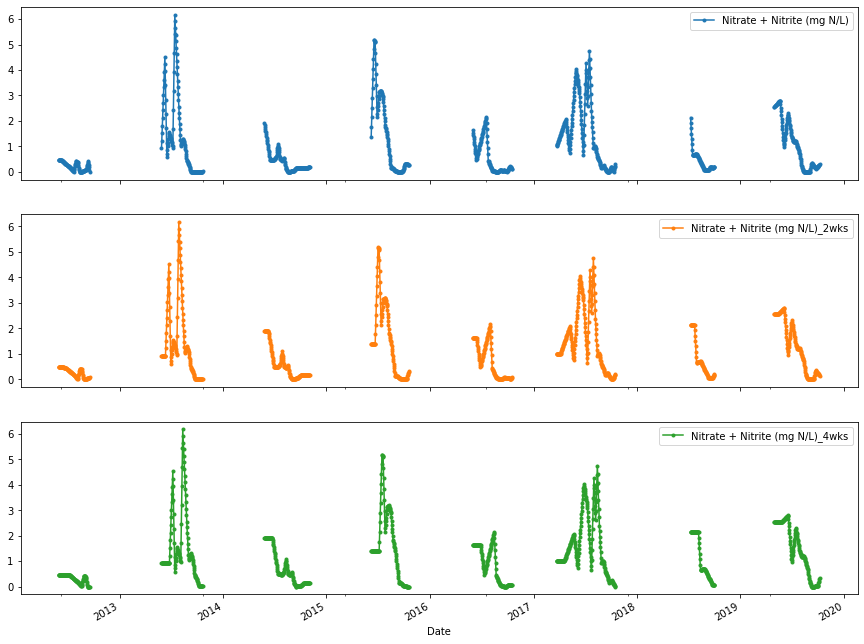

In [124]:
timeplot(we2.reset_index(), ['Nitrate + Nitrite (mg N/L)','Nitrate + Nitrite (mg N/L)_2wks','Nitrate + Nitrite (mg N/L)_4wks'])